In [1]:
%matplotlib inline

In [2]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


C:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  


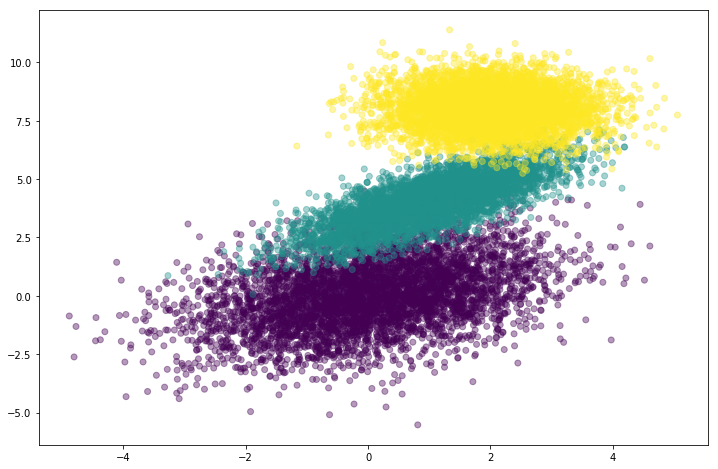

In [3]:
np.random.seed(12)
num_observations = 5000

x1 = np.random.multivariate_normal([0, 0], [[2, .75],[.75, 2]], num_observations)
x2 = np.random.multivariate_normal([1, 4], [[1, .75],[.75, 1]], num_observations)
x3 = np.random.multivariate_normal([2, 8], [[0, .75],[.75, 0]], num_observations)

simulated_separableish_features = np.vstack((x1, x2, x3)).astype(np.float32)
simulated_labels = np.hstack((np.zeros(num_observations),
				np.ones(num_observations), np.ones(num_observations) + 1))

plt.figure(figsize=(12,8))
plt.scatter(simulated_separableish_features[:, 0], simulated_separableish_features[:, 1],
            c = simulated_labels, alpha = .4)


In [4]:
labels_onehot = np.zeros((simulated_labels.shape[0], 3)).astype(int)
labels_onehot[np.arange(len(simulated_labels)), simulated_labels.astype(int)] = 1

train_dataset, test_dataset, \
train_labels, test_labels = train_test_split(
    simulated_separableish_features, labels_onehot, test_size = .1, random_state = 12)

In [5]:
hidden_nodes = 5
num_labels = train_labels.shape[1]
batch_size = 100
num_features = train_dataset.shape[1]
learning_rate = .01

graph = tf.Graph()
with graph.as_default():
    
    # Data
    tf_train_dataset = tf.placeholder(tf.float32, shape = [None, num_features])
    tf_train_labels = tf.placeholder(tf.float32, shape = [None, num_labels])
    tf_test_dataset = tf.constant(test_dataset)
  
    # Weights and Biases
    layer1_weights = tf.Variable(tf.truncated_normal([num_features, hidden_nodes]))
    layer1_biases = tf.Variable(tf.zeros([hidden_nodes]))
    
    layer2_weights = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels]))
    layer2_biases = tf.Variable(tf.zeros([num_labels]))
    
    # Three-Layer Network
    def three_layer_network(data):
        input_layer = tf.matmul(data, layer1_weights)
        hidden = tf.nn.relu(input_layer + layer1_biases)
        output_layer = tf.matmul(hidden, layer2_weights) + layer2_biases
        return output_layer
    
    # Model Scores
    model_scores = three_layer_network(tf_train_dataset)
    
    # Loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model_scores, labels=tf_train_labels))
  
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    # Predictions
    train_prediction = tf.nn.softmax(model_scores)
    test_prediction = tf.nn.softmax(three_layer_network(tf_test_dataset))


In [6]:
def accuracy(predictions, labels):
    preds_correct_boolean =  np.argmax(predictions, 1) == np.argmax(labels, 1)
    correct_predictions = np.sum(preds_correct_boolean)
    accuracy = 100.0 * correct_predictions / predictions.shape[0]
    return accuracy


In [7]:
num_steps = 10001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        minibatch_data = train_dataset[offset:(offset + batch_size), :]
        minibatch_labels = train_labels[offset:(offset + batch_size)]
        
        feed_dict = {tf_train_dataset : minibatch_data, tf_train_labels : minibatch_labels}
        
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict = feed_dict
            )
        
        if step % 1000 == 0:
            print ('Minibatch loss at step {0}: {1}'.format(step, l))

    print ('Test accuracy: {0}%'.format(accuracy(test_prediction.eval(), test_labels)))


Instructions for updating:
Use `tf.global_variables_initializer` instead.
Minibatch loss at step 0: 1.5653048753738403
Minibatch loss at step 1000: 0.7443832159042358
Minibatch loss at step 2000: 0.6414580345153809
Minibatch loss at step 3000: 0.45074382424354553
Minibatch loss at step 4000: 0.28043055534362793
Minibatch loss at step 5000: 0.23123851418495178
Minibatch loss at step 6000: 0.18925277888774872
Minibatch loss at step 7000: 0.12991531193256378
Minibatch loss at step 8000: 0.09654048830270767
Minibatch loss at step 9000: 0.10339315235614777
Minibatch loss at step 10000: 0.12383204698562622
Test accuracy: 96.6%
